In [1]:
%config Completer.use_jedi = False

In [5]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchinfo import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import utils
from dataset import MyCocoDetection, MyCocoLimit, coco_show

%matplotlib inline

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

transform = A.Compose([
    A.Resize(width=512, height=512),
#     A.Rotate(limit=40,p=0.9),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=[]))

train_path = r'C:\Users\gjust\Documents\Github\data\COCO\train2017'
train_ann = r'C:\Users\gjust\Documents\Github\data\COCO\annotations\instances_train2017.json'
test_path = r'C:\Users\gjust\Documents\Github\data\COCO\val2017'
test_ann = r'C:\Users\gjust\Documents\Github\data\COCO\annotations\instances_val2017.json'
class_list = ['person']

trainset = MyCocoLimit(root=train_path, annFile=train_ann, class_list=class_list, transform=transform)
testset = MyCocoLimit(root=test_path, annFile=test_ann, class_list=class_list, transform=transform)
train_loader = DataLoader(trainset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size=2, shuffle=False, collate_fn=collate_fn)

print(len(testset))

loading annotations into memory...
Done (t=16.96s)
creating index...
index created!
loading annotations into memory...
Done (t=3.35s)
creating index...
index created!
2692


# Visualization

ValueError: Expected x_max for bbox (0.534265625, 0.7004374999999999, 1.2842656250000002, 1.5873958333333333) to be in the range [0.0, 1.0], got 1.2842656250000002.

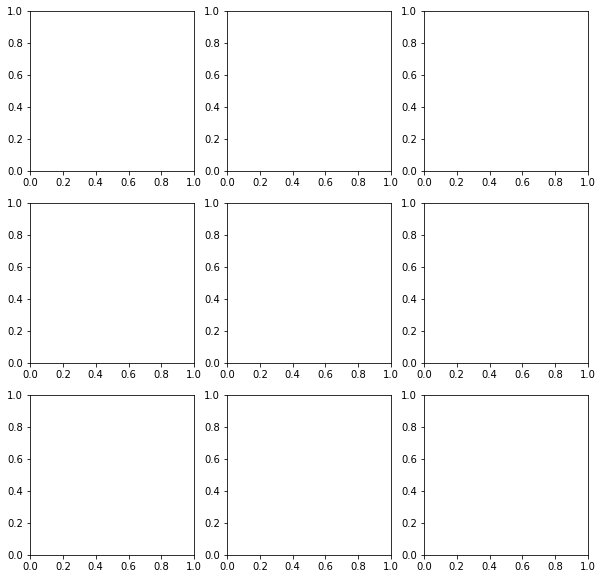

In [5]:
coco_show(trainset, shape=(3,3))

# CUDA

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Model

In [7]:
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = len(class_list) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
summary(model, (2,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              --                        --
├─BackboneWithFPN: 1                                    --                        --
│    └─FeaturePyramidNetwork: 2                         --                        --
│    │    └─ModuleList: 3-1                             --                        984,064
│    │    └─ModuleList: 3-2                             --                        2,360,320
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [2, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [2, 2048, 25, 25]         --
│    │    └─Conv2d: 3-3                                 [2, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-4                      [2, 64, 400, 400]         --
│    │    └─ReLU: 3-5                      

In [12]:
with torch.no_grad():
    model.eval()
    idx, images, targets = iter(train_loader).next()
    images = [img.to(device) for img in images]
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
#     print(images)
#     print(targets)
    print(model(images, targets))

ValueError: Expected x_max for bbox (0.65225, 0.13258333333333333, 1.5522500000000001, 1.1191041666666666) to be in the range [0.0, 1.0], got 1.5522500000000001.

In [28]:
def coco2pascal(bboxes):
    new_bboxes = torch.zeros_like(bboxes)
    new_bboxes[:,:2] = bboxes[:, :2]
    new_bboxes[:, 2:] = bboxes[:, :2] + bboxes[:, 2:]
    
    return new_bboxes

# Optimizer

In [29]:
import torch.optim as optim

# from torch.optim.lr_scheduler import StepLR

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# Train

In [11]:
testset.class_list

['person', 'dog', 'car', 'keyboard', 'horse']

In [31]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [32]:
import time

train_loss_per_epoch_list = []
train_loss_per_iter_list = []
EPOCH = 1
model.train()
for e in range(EPOCH):
        
    for i, (idx, images, targets) in enumerate(train_loader):
        start = time.time()
        images = [img.to(device) for img in images]
        new_targets = []
        for t in targets:
            t['boxes'] = coco2pascal(t['boxes'])
            new_targets.append({k:v.to(device) for k,v in t.items()})
        
        loss_dict = model(images, new_targets)
        loss = sum(v for v in loss_dict.values())
        train_loss_per_iter_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        end = time.time()
        if i % 10 == 0:
            print('EPOCH : [%d/%d] ---- Iter : [%d/%d] ---- Loss : %0.3f --- Time : %0.3f'
                 % (e+1, EPOCH, i, len(train_loader), loss, (end-start)*10))
            
    train_loss_per_epoch_list.append(loss)        
    print('EPOCH : [%d/%d] ---- Iter : [%d/%d] ---- Loss : %0.3f --- Time : %0.3f \n'
            % (e+1, EPOCH, i, len(train_loader), loss, end-start))

EPOCH : [1/1] ---- Iter : [0/42881] ---- Loss : 2.576 --- Time : 3.556


RuntimeError: CUDA error: device-side assert triggered

# Inference

In [13]:
with torch.no_grad():
    model.eval()
    
    total_gt_bboxes = torch.tensor([])
    total_pred_bboxes = torch.tensor([])
    with tqdm(test_loader, unit='iter') as iters:
        for i, (img_ids, images, targets) in enumerate(iters):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img_id, target, output in zip(img_ids, targets, outputs):
                gt_bboxes = get_bbox(img_id, target)
                pred_bboxes = get_bbox(img_id, output, pred=True)

                total_gt_bboxes = torch.cat([total_gt_bboxes, gt_bboxes])
                total_pred_bboxes = torch.cat([total_pred_bboxes, pred_bboxes])

      #      print('r\')
        
print('Shape of total ground Truths bboxes :', total_gt_bboxes.shape)
print('Shape of total predicted bboxes :', total_pred_bboxes.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1819/1819 [06:17<00:00,  4.82iter/s]

Shape of total ground Truths bboxes : torch.Size([17912, 6])
Shape of total predicted bboxes : torch.Size([363800, 7])


# mAP

In [15]:
mAP, AP_per_classes = mean_average_precision(total_pred_bboxes,
                                             total_gt_bboxes,
                                             iou_threshold=0.5,
                                             box_format='corner',
                                             num_classes=5)
print('mAP :', mAP)
print(AP_per_classes)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.50s/class]

mAP : tensor(0.0002)
tensor([0.0000, 0.0001, 0.0000, 0.0007, 0.0000])
